In [34]:
from IPython.display import display, Markdown
from definiciones import graficar_gini, gini, criterio_equilibrio, gini_barrio, satisfechos_en, crear_simulador, crear_modelo
from numpy.random import default_rng as random_number_generator
from tp.schelling import mercado_inmobiliario
from tp.util.barrios import Mapa
from tp.util import simulador
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

# Schelling cambiando el rango de visión

### Introducción
El siguiente trabajo se basa en el modelo original de Schelling inmobiliario, un modelo de autómata celular. En este modelo tenemos 2 grupos distribuidos de manera aleatoria, donde cada agente busca estar junto con gente de su grupo. Definimos una función de utilidad por posición, la cual está dada por el capital (se le da mayor o menor importancia según una variable alpha) y el valor que el agente le asigna a la propiedad (que depende de la cantidad de vecinos iguales o distintos que tiene). Se eligen a 2 agentes de manera random (considerando todos los agentes) y solo intercambian posición si mejora la función de utilidad de ambos.

Al realizar ciertas modificaciones al modelo original, buscamos que se asemeje más a la realidad. Generalmente, cuando alguien se muda, no lo hace muy lejos de su lugar de residencia original, ya que no quiere cambiar de escuela, amigos, etc. Además, mudarse a otro barrio puede implicar distintos costos, dependiendo de cuál sea el barrio. Por lo tanto, a través de diversos experimentos, intentaremos responder a la siguiente pregunta: ¿Cómo varía la cantidad de satisfechos en el estado de equilibrio, si existe, en función de distintos rangos de visión, considerando diversos costos de mudanza y costo de propiedad según el barrio? 

Además, para poder responder a la pregunta anterior vimos el índice de Gini en cada uno de los experimentos variando diversos parámetros. REVISAR

Por lo tanto, debido a las modificaciones que le debemos hacer al modelo original para responder la pregunta en cuestión, en este caso, tendremos una grilla de tamaño L=50 donde a cada posición se le corresponde un barrio definido (cada barrio es un conjunto de casillas contiguas). De la misma manera que el modelo original, cada agente comenzará con cierto capital inicial que definiremos como hiperparámetro del modelo. Además, introducimos el concepto de “rango de visión”, que le dice a un agente qué tanto se puede mover dentro de la grilla. Este rango es un porcentaje del tamaño de la grilla L, es decir, si tiene un 0.5 de visión, entonces el agente considera mudarse a casillas que se encuentren dentro del 50% de la grilla alrededor de su posición. Por lo tanto, cada uno de los agentes va a tener la posibilidad de intercambiar posición con alguien dentro de su rango de visión. 

Además, introdujimos la modificación de que al mudarse a cierto barrio, hay un costo de mudanza específico para cada uno. Es intuitivo que en los barrios más caros sea más caro el costo de mudanza. Por lo tanto, esto va a afectar en la capacidad de mudarse de cada uno de los agentes, pues al considerar mudarse a otra posición se deberá tener en cuenta si tiene capital suficiente para el valor de la casa, el costo de mudanza y si le suma utilidad mudarse.



Para los experimentos, consideramos 4 barrios distintos posibles, con diferente precio de propiedades y mudanza. El barrio 1 es el más caro, y el barrio 4 el más barato.
| Barrio | Precio de mudanza | Precio de Propiedades | Color   |
|--------|-------------------|-----------------------|---------|
| 1      | 3.0               | 1.35                  | Rojo    |
| 2      | 2.25              | 1.0125                | Azul    |
| 3      | 1.2               | 0.54                  | Verde   |
| 4      | 0.15              | 0.0675                | Naranja |

Luego de probar varios valores posibles para los precios de mudanza y propiedades, elegimos los que daban resultados más interesantes.

Se realizaron dos experimentos con dos grillas distintas, una de cuatro cuadrantes (teniendo en cuenta los 4 barrios) y otra de tres tercios (teniendo en cuenta sólo 3). Para ambos, dejamos fijo un valor de alpha de entre los siguientes valores posibles:
* α = 0.1
* α = 0.4
* α = 0.8

Para cada uno de estos, se realizó un cambió en el rango de visión realizando 1000 iteraciones, es decir, creamos de forma equiespaciada 1000 valores entre 0 y 1. 
Además, se tuvieron en cuenta dos valores de configuración inicial máxima, es decir, start_max. Estos valores fueron 1 y 10. Los valores de las configuraciones iniciales para cada agente, se definieron de manera random con números elegidos de manera uniforme entre 0 y start_max.


In [23]:
N = 50 # Tamaño de la grilla

alphas = [
    .1,
    .4,
    .8   
]

subdivisiones = 10
rangos_de_vision = np.linspace(0,1, subdivisiones)


# Generador de numeros aleatorios para Numpy
rng = random_number_generator(seed=1)

---
# Grilla cuatro cuadrantes
Para el primer experimento, tuvimos en cuenta una grilla que está separada por los 4 barrios de forma que se tienen cuatro cuadrantes del mismo tamaño. 


Mapa(mapa=array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3]]), barrios_definidos=[Barrio(precio_propiedades=1.35, precio_mudanza=3.0, color='#E15759'), Barrio(precio_propiedades=1.0125, precio_mudanza=2.25, color='#4E79A7'), Barrio(precio_propiedades=0.54, precio_mudanza=1.2, color='#59A14F'), Barrio(precio_propiedades=0.0675, precio_mudanza=0.15, color='#F28E2B'), Barrio(precio_propiedades=1.35, precio_mudanza=3.0, color='#4285F4'), Barrio(precio_propiedades=1.0125, precio_mudanza=2.25, color='#EA4335'), Barrio(precio_propiedades=0.74, precio_mudanza=1.2, color='#FBBC04'), Barrio(precio_propiedades=0.3675, precio_mudanza=0.15, color='#34A853')], image_bytes=None)
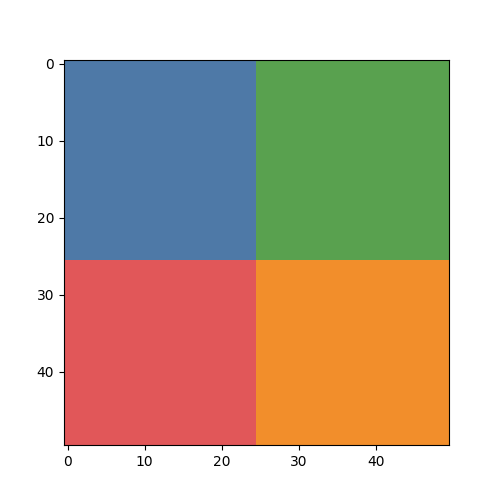

<Figure size 640x480 with 0 Axes>

In [3]:
mapa = Mapa.load('../src/tp/mapas/cuatro_cuadrantes.txt', '../src/tp/barrios.json')
display(mapa)

In [4]:
display(Markdown("### Barrios disponibles en el mapa 'Cuatro cuadrantes'"))
display(mapa.barrios_info().iloc[:4][['Precio Propiedades', 'Precio Mudanza']])

### Barrios disponibles en el mapa 'Cuatro cuadrantes'

,Precio Propiedades,Precio Mudanza
Barrio 1,1.3500,3.00
Barrio 2,1.0125,2.25
Barrio 3,0.5400,1.20
Barrio 4,0.0675,0.15


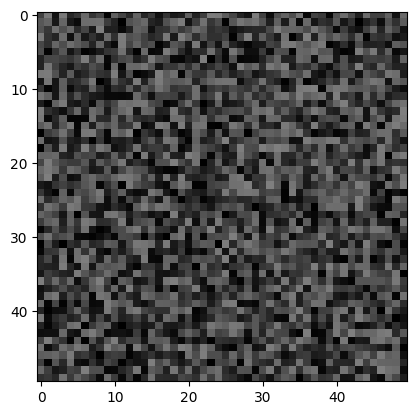

In [5]:
start_max = 10
range_max = 20 # Máximo para el rango de colores.
capital_inicial = rng.uniform(0, start_max, (N,N))

plt.imshow(capital_inicial, cmap='grey', norm=plt.Normalize(0, range_max))
plt.show()

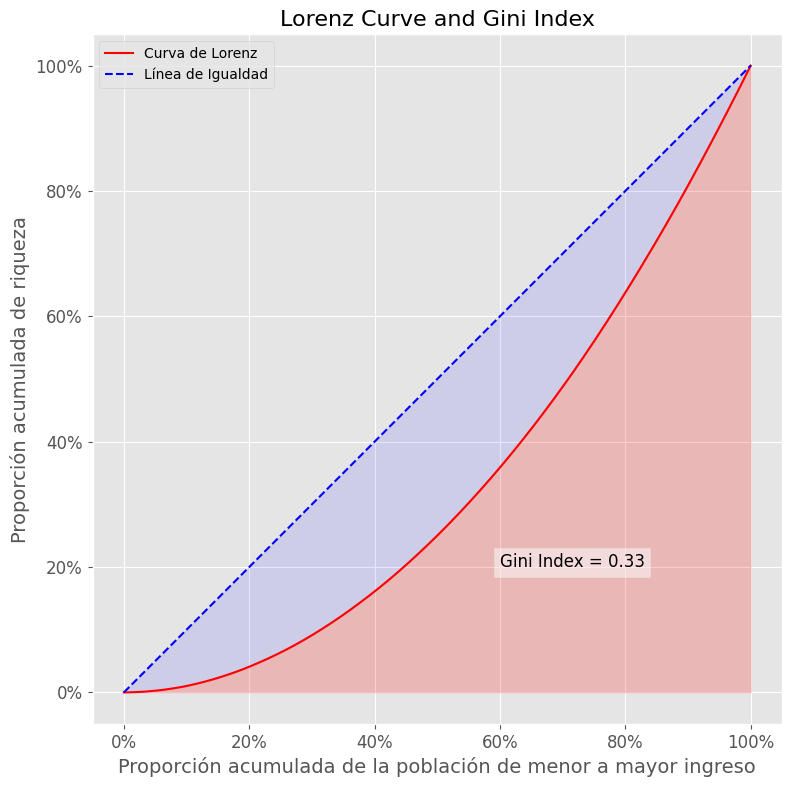

In [6]:
graficar_gini(capital_inicial.flatten(), gini(capital_inicial.flatten())).show()

In [7]:
def gini_total(modelo):
    return gini(modelo.K.flatten())

caching_actions = ( # mediciones
    mercado_inmobiliario.utilidad_media,
    mercado_inmobiliario.capital_medio,
    gini_total,
    *(gini_barrio(x) for x in mapa.barrios),
    *(satisfechos_en(x) for x in mapa.barrios),
)

In [8]:
modelo = mercado_inmobiliario(
    L=N, 
    alpha=.8,
    rng=rng, 
    mapa = mapa,
    rango_de_vision=0.15,
    capital_inicial=capital_inicial,
)

In [9]:
sim = simulador(modelo, 
               criterio_equilibrio, 
               max_steps=int(1e3), 
               lag=20, 
               tol=1e-3, 
               cache_actions=caching_actions)

In [10]:
sim.run()

 48%|████▊     | 478/1000 [00:25<00:27, 18.69it/s]

La simulación alcanzó el equilibrio en 478 pasos.


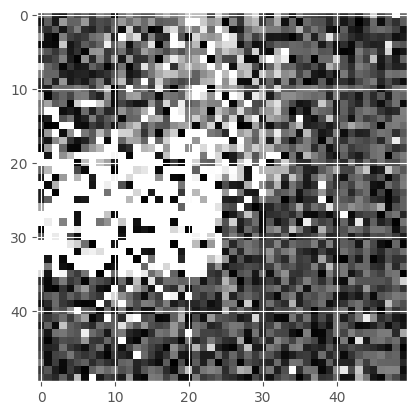

In [11]:
plt.imshow(modelo.K, cmap='grey', norm=plt.Normalize(0, range_max))
plt.show()

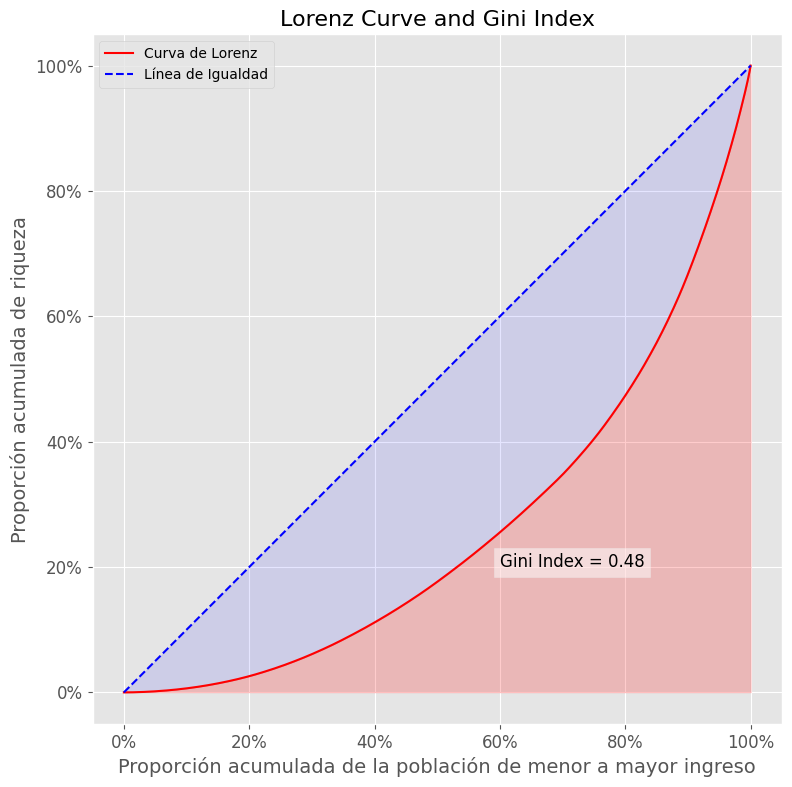

In [12]:
graficar_gini(modelo.K.flatten(), gini(modelo.K.flatten())).show()

## Cambiando el rango de visión

In [26]:
caching_actions = (
    mercado_inmobiliario.utilidad_media,
    mercado_inmobiliario.capital_medio,
)

M = len(alphas) * len(rangos_de_vision)
config_iniciales = rng.uniform(0, start_max, (M, N, N))

# M matrices de N x N
print(config_iniciales.shape)

(30, 50, 50)


In [27]:
modelos = [None for _ in range(M)]
simuladores = [crear_simulador(caching_actions) for _ in range(M)]

i = 0
for alpha in alphas:
    for r in rangos_de_vision:
        modelos[i] = crear_modelo(alpha, r, rng, mapa, capital_inicial=config_iniciales[i])
        simuladores[i] = simuladores[i](modelos[i])
        i += 1

In [28]:
for sim in tqdm(simuladores):
    sim.run()

  3%|▎         | 1/30 [00:00<00:25,  1.15it/s]

La simulación alcanzó el equilibrio en 20 pasos.


  7%|▋         | 2/30 [00:05<01:30,  3.25s/it]

La simulación alcanzó el equilibrio en 101 pasos.


 10%|█         | 3/30 [00:11<01:56,  4.32s/it]

La simulación alcanzó el equilibrio en 90 pasos.


 13%|█▎        | 4/30 [00:17<02:08,  4.95s/it]

La simulación alcanzó el equilibrio en 77 pasos.


 17%|█▋        | 5/30 [00:24<02:24,  5.79s/it]

La simulación alcanzó el equilibrio en 80 pasos.


 20%|██        | 6/30 [00:32<02:39,  6.65s/it]

La simulación alcanzó el equilibrio en 82 pasos.


 23%|██▎       | 7/30 [00:40<02:43,  7.09s/it]

La simulación alcanzó el equilibrio en 74 pasos.


 27%|██▋       | 8/30 [00:48<02:37,  7.17s/it]

La simulación alcanzó el equilibrio en 67 pasos.


 30%|███       | 9/30 [00:58<02:49,  8.07s/it]

La simulación alcanzó el equilibrio en 92 pasos.


 33%|███▎      | 10/30 [01:07<02:48,  8.42s/it]

La simulación alcanzó el equilibrio en 84 pasos.


 37%|███▋      | 11/30 [01:08<01:56,  6.11s/it]

La simulación alcanzó el equilibrio en 20 pasos.


 40%|████      | 12/30 [01:14<01:49,  6.10s/it]

La simulación alcanzó el equilibrio en 127 pasos.


 43%|████▎     | 13/30 [01:22<01:53,  6.67s/it]

La simulación alcanzó el equilibrio en 130 pasos.


 47%|████▋     | 14/30 [01:33<02:08,  8.04s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 50%|█████     | 15/30 [01:46<02:24,  9.61s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 53%|█████▎    | 16/30 [02:01<02:35, 11.14s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 57%|█████▋    | 17/30 [02:18<02:45, 12.75s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 60%|██████    | 18/30 [02:35<02:48, 14.05s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 63%|██████▎   | 19/30 [02:51<02:42, 14.75s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 67%|██████▋   | 20/30 [03:07<02:31, 15.20s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 70%|███████   | 21/30 [03:08<01:38, 10.90s/it]

La simulación alcanzó el equilibrio en 20 pasos.


 73%|███████▎  | 22/30 [03:16<01:18,  9.85s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 77%|███████▋  | 23/30 [03:25<01:07,  9.63s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 80%|████████  | 24/30 [03:37<01:01, 10.31s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 83%|████████▎ | 25/30 [03:50<00:56, 11.31s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 87%|████████▋ | 26/30 [04:05<00:50, 12.51s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 90%|█████████ | 27/30 [04:22<00:40, 13.59s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 93%|█████████▎| 28/30 [04:38<00:29, 14.50s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 97%|█████████▋| 29/30 [04:55<00:15, 15.28s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


100%|██████████| 30/30 [05:12<00:00, 10.41s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


In [29]:
result = []

for s in simuladores:
    observaciones = s._cache
    alpha = s.modelo.alpha
    rango = s.modelo.rango_de_vision
    satisfechos_finales = s.modelo.satisfechos().sum()
    result.append({
        'observaciones': observaciones,
        'alpha': alpha,
        'rango': rango,
        'satisfechos': [
            satisfechos_en(0)(s.modelo),
            satisfechos_en(1)(s.modelo),
            satisfechos_en(2)(s.modelo),
            satisfechos_en(3)(s.modelo)
        ]
    })

In [31]:
satisfaccion_por_rango_alpha01 = dict[float, list[float]]()
satisfaccion_por_rango_alpha04 = dict[float, list[float]]()
satisfaccion_por_rango_alpha08 = dict[float, list[float]]()

for cache in result:
    alpha = cache['alpha']
    rango = cache['rango']

    if alpha == .8:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha08.setdefault(rango, []).append(satisfaccion)

    if alpha == .4:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha04.setdefault(rango, []).append(satisfaccion)

    if alpha == .1:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha01.setdefault(rango, []).append(satisfaccion)

In [32]:
habitantes_por_barrio = [
    (mapa.mapa == i).sum()
    for i in range(4)
]

(0.0, 100.0)

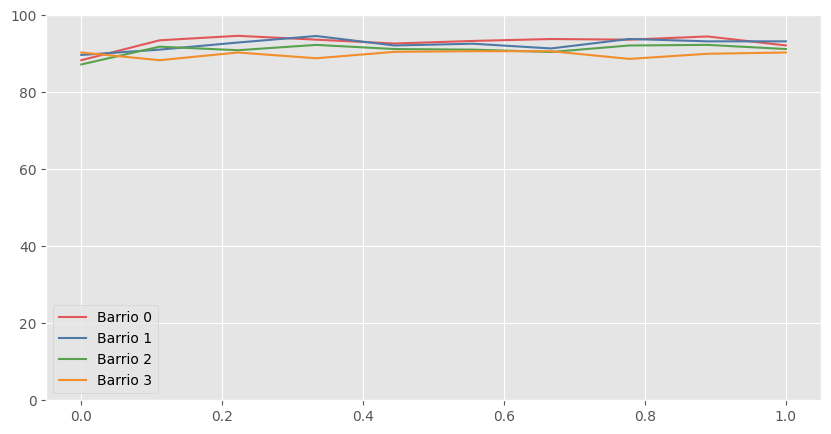

In [37]:
df = pd.DataFrame(satisfaccion_por_rango_alpha08).T
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=mapa.barrios_definidos[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)

(0.0, 100.0)

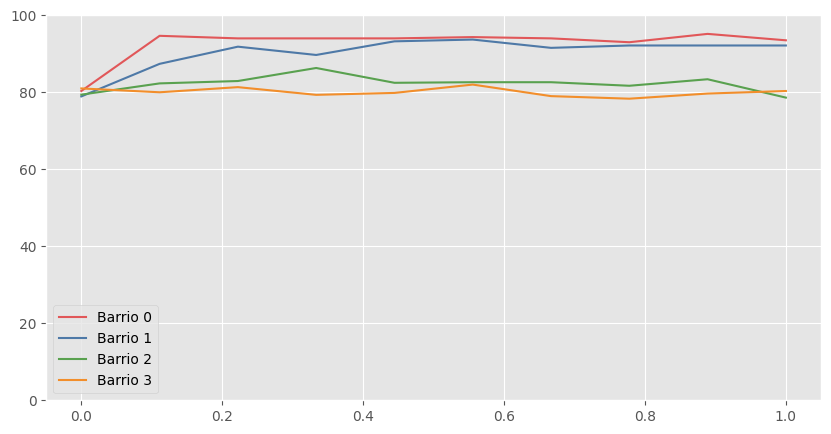

In [39]:
df = pd.DataFrame(satisfaccion_por_rango_alpha04).T
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=mapa.barrios_definidos[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)

(0.0, 100.0)

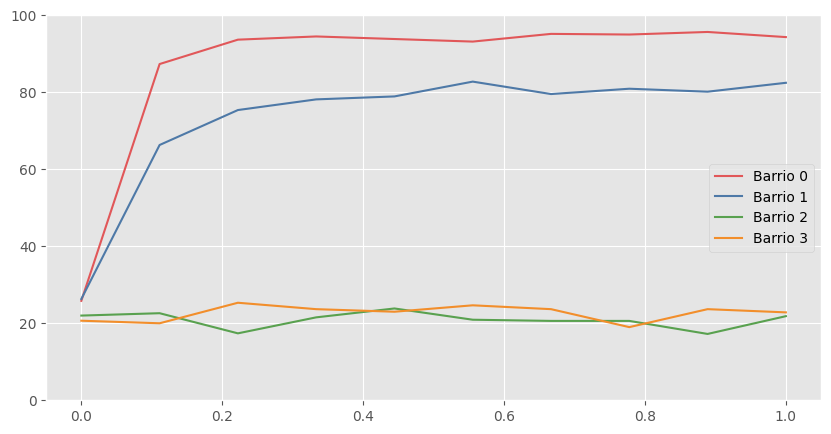

In [40]:
df = pd.DataFrame(satisfaccion_por_rango_alpha01).T
fig = plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=mapa.barrios_definidos[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)

---

# Grilla tercio

Para el segundo experimento, tuvimos en cuenta una grilla que está separada por los primero 3 barrios de forma que se tienen tres tercios del mismo tamaño, dejándo afuera el último barrio (el más barato). s

In [43]:
rng = random_number_generator(seed=1) # Reseteo el generador

Mapa(mapa=array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]]), barrios_definidos=[Barrio(precio_propiedades=1.35, precio_mudanza=3.0, color='#E15759'), Barrio(precio_propiedades=1.0125, precio_mudanza=2.25, color='#4E79A7'), Barrio(precio_propiedades=0.54, precio_mudanza=1.2, color='#59A14F'), Barrio(precio_propiedades=0.0675, precio_mudanza=0.15, color='#F28E2B'), Barrio(precio_propiedades=1.35, precio_mudanza=3.0, color='#4285F4'), Barrio(precio_propiedades=1.0125, precio_mudanza=2.25, color='#EA4335'), Barrio(precio_propiedades=0.74, precio_mudanza=1.2, color='#FBBC04'), Barrio(precio_propiedades=0.3675, precio_mudanza=0.15, color='#34A853')], image_bytes=None)
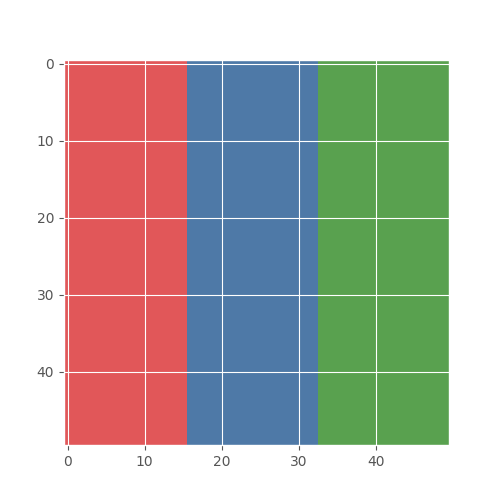

In [44]:
mapa = Mapa.load('../src/tp/mapas/tercios.txt', '../src/tp/barrios.json')
display(mapa)

In [45]:
display(mapa.barrios_info().iloc[:3][['Precio Propiedades', 'Precio Mudanza']])

,Precio Propiedades,Precio Mudanza
Barrio 1,1.3500,3.00
Barrio 2,1.0125,2.25
Barrio 3,0.5400,1.20


## Cambiando el rango de visión

In [46]:
caching_actions = (
    mercado_inmobiliario.utilidad_media,
    mercado_inmobiliario.capital_medio,
)

M = len(alphas) * len(rangos_de_vision)
config_iniciales = rng.uniform(0, start_max, (M, N, N))

# M matrices de N x N
print(config_iniciales.shape)

(30, 50, 50)


In [47]:
modelos = [None for _ in range(M)]
simuladores = [crear_simulador(caching_actions) for _ in range(M)]

i = 0
for alpha in alphas:
    for r in rangos_de_vision:
        modelos[i] = crear_modelo(alpha, r, rng, mapa, capital_inicial=config_iniciales[i])
        simuladores[i] = simuladores[i](modelos[i])
        i += 1

In [48]:
for sim in tqdm(simuladores):
    sim.run()

  3%|▎         | 1/30 [00:00<00:27,  1.06it/s]

La simulación alcanzó el equilibrio en 20 pasos.


  7%|▋         | 2/30 [00:08<02:10,  4.66s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 10%|█         | 3/30 [00:15<02:36,  5.80s/it]

La simulación alcanzó el equilibrio en 111 pasos.


 13%|█▎        | 4/30 [00:23<02:57,  6.83s/it]

La simulación alcanzó el equilibrio en 109 pasos.


 17%|█▋        | 5/30 [00:33<03:12,  7.70s/it]

La simulación alcanzó el equilibrio en 100 pasos.


 20%|██        | 6/30 [00:41<03:11,  7.99s/it]

La simulación alcanzó el equilibrio en 86 pasos.


 23%|██▎       | 7/30 [00:49<03:02,  7.94s/it]

La simulación alcanzó el equilibrio en 74 pasos.


 27%|██▋       | 8/30 [01:00<03:13,  8.80s/it]

La simulación alcanzó el equilibrio en 97 pasos.


 30%|███       | 9/30 [01:09<03:06,  8.89s/it]

La simulación alcanzó el equilibrio en 83 pasos.


 33%|███▎      | 10/30 [01:18<03:02,  9.10s/it]

La simulación alcanzó el equilibrio en 86 pasos.


 37%|███▋      | 11/30 [01:19<02:05,  6.59s/it]

La simulación alcanzó el equilibrio en 20 pasos.


 40%|████      | 12/30 [01:26<01:58,  6.60s/it]

La simulación alcanzó el equilibrio en 138 pasos.


 43%|████▎     | 13/30 [01:35<02:04,  7.33s/it]

La simulación alcanzó el equilibrio en 143 pasos.


 47%|████▋     | 14/30 [01:46<02:16,  8.53s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 50%|█████     | 15/30 [01:59<02:28,  9.90s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 53%|█████▎    | 16/30 [02:14<02:38, 11.35s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 57%|█████▋    | 17/30 [02:30<02:47, 12.87s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 60%|██████    | 18/30 [02:47<02:47, 13.99s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 63%|██████▎   | 19/30 [03:03<02:40, 14.60s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 67%|██████▋   | 20/30 [03:19<02:31, 15.16s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 70%|███████   | 21/30 [03:20<01:37, 10.88s/it]

La simulación alcanzó el equilibrio en 20 pasos.


 73%|███████▎  | 22/30 [03:27<01:18,  9.78s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 77%|███████▋  | 23/30 [03:37<01:07,  9.60s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 80%|████████  | 24/30 [03:48<01:01, 10.20s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 83%|████████▎ | 25/30 [04:02<00:55, 11.14s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 87%|████████▋ | 26/30 [04:17<00:49, 12.37s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 90%|█████████ | 27/30 [04:34<00:41, 13.69s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 93%|█████████▎| 28/30 [04:50<00:29, 14.63s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


 97%|█████████▋| 29/30 [05:07<00:15, 15.35s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


100%|██████████| 30/30 [05:24<00:00, 10.83s/it]

La simulación no alcanzó el equilibrio en 149 pasos.


In [49]:
result = []

for s in simuladores:
    observaciones = s._cache
    alpha = s.modelo.alpha
    rango = s.modelo.rango_de_vision
    satisfechos_finales = s.modelo.satisfechos().sum()
    result.append({
        'observaciones': observaciones,
        'alpha': alpha,
        'rango': rango,
        'satisfechos': [
            satisfechos_en(0)(s.modelo),
            satisfechos_en(1)(s.modelo),
            satisfechos_en(2)(s.modelo),
            satisfechos_en(3)(s.modelo)
        ]
    })

In [50]:
satisfaccion_por_rango_alpha01 = dict[float, list[float]]()
satisfaccion_por_rango_alpha04 = dict[float, list[float]]()
satisfaccion_por_rango_alpha08 = dict[float, list[float]]()

for cache in result:
    alpha = cache['alpha']
    rango = cache['rango']

    if alpha == .8:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha08.setdefault(rango, []).append(satisfaccion)

    if alpha == .4:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha04.setdefault(rango, []).append(satisfaccion)

    if alpha == .1:
        for satisfaccion in cache['satisfechos']:
            satisfaccion_por_rango_alpha01.setdefault(rango, []).append(satisfaccion)

In [51]:
habitantes_por_barrio = [
    (mapa.mapa == i).sum()
    for i in range(3)
]

<Figure size 640x480 with 0 Axes>

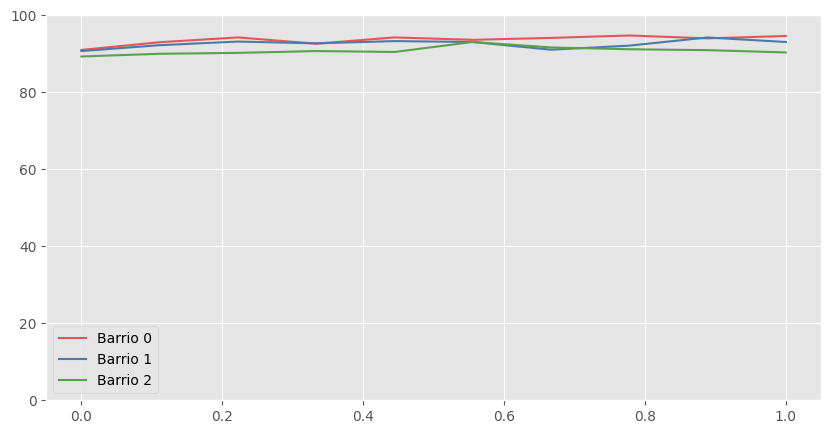

In [55]:
df = pd.DataFrame(satisfaccion_por_rango_alpha08).T
fig = plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=mapa.barrios_definidos[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)
plt.show()

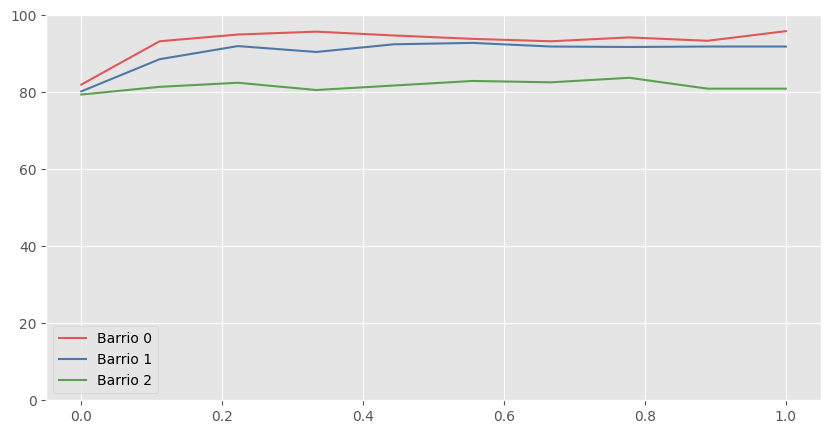

In [56]:
df = pd.DataFrame(satisfaccion_por_rango_alpha04).T
fig = plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=mapa.barrios_definidos[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)
plt.show()

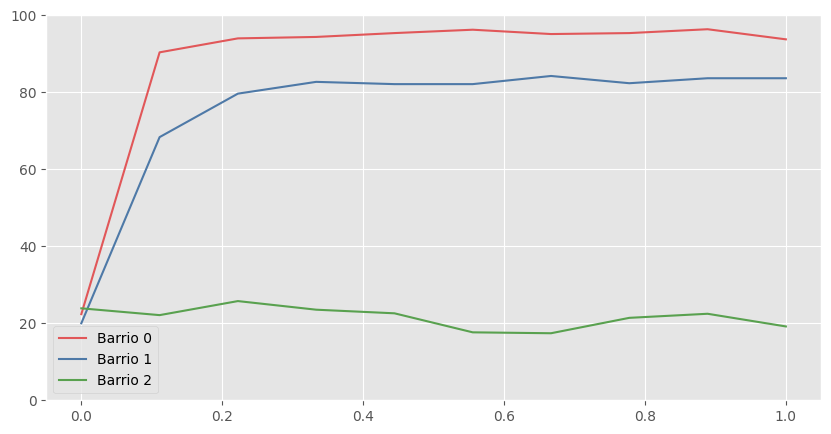

In [57]:
df = pd.DataFrame(satisfaccion_por_rango_alpha01).T
fig = plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(100*df[i]/habitantes_por_barrio[i], label=f'Barrio {i}', color=mapa.barrios_definidos[i].color)

legend = plt.legend()
for t in legend.get_texts():
    t.set_color('black')

plt.ylim(0,100)
plt.show()